In [1]:
# ==============================================
# Diffusion Model Training Notebook
# ==============================================
# Author: [Han Zhang]
# Date: [10/03/04]
# Purpose: End-to-end demonstration of training a diffusion model on preliminary data
# ==============================================

In [1]:
# --- Import Necessary Libraries ---
import os  # For file handling
import csv # For saving data to CSV
from datetime import datetime # For timestamping
import math 
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualization
import scipy.io as sio  # For handling MATLAB .mat files
import h5py
import torch  # PyTorch: deep learning framework
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functions for neural networks
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split # Data handling
from tqdm import tqdm  # Progress bar
from sklearn.preprocessing import MinMaxScaler  # Scaling data (optional)
#from segmentation_models_pytorch import Unet


In [2]:
# --- File Paths ---
# Define file paths (modify these for your datasets)
# MATLAB_FILE_PATH = "A:/Research/Projects/Metamaterial Geometry Bandgap Dataset Generator/2D-dispersion/complete_datasets/complete_dataset_control_32pix.mat"   
# MATLAB_FILE_PATH = "C:/Users/hz283/Documents/Duke/Research/2D-dispersion/complete_datasets/complete_dataset_control_32pix.mat"  
# MATLAB_FILE_PATH = "C:/Users/hz283/Documents/Duke/Research/Diffusion-Model-2D-Metamaterials/datasets/datasets/complete_datasets/complete_control_big_nosym.mat" 
MATLAB_FILE_PATH = "C:/Users/hz283/Documents/Duke/Research/Diffusion-Model-2D-Metamaterials/datasets/datasets/complete_datasets/control_sigF20_sigLCombo_sr90.mat" 
OUTPUT_DIRECTORY = "output/"  # Directory to save results/models

In [3]:
with h5py.File(MATLAB_FILE_PATH, 'r') as f:
    # Print available variables
    print("Variables in the .mat file:", list(f.keys()))
    
    # Extract and process designs
    designs_raw = np.array(f['designs'])
    print("Designs raw shape:", designs_raw.shape)
    
    # Extract bandgap data
    bandgap_widths = np.array(f['bandgap_widths'])
    print("Bandgap widths raw shape:", bandgap_widths.shape)
    largest_bandgap_widths = np.max(bandgap_widths, axis=1)
    bandgap_eigenmode_indices = np.argmax(bandgap_widths, axis=1)
    
    bandgap_locations = np.array(f['bandgap_locations'])
    print("Bandgap locations raw shape:", bandgap_locations.shape)
    
    # Get the bandgap locations corresponding to largest widths using eigenmode indices
    largest_bandgap_locations = bandgap_locations[np.arange(len(bandgap_eigenmode_indices)), bandgap_eigenmode_indices]
    
    # Process designs - drop redundant 3rd dimension
    # designs = np.transpose(designs_raw, (3, 0, 1, 2))[..., 0]
    designs = designs_raw[:,0,:,: ]
    print("Designs processed shape:", designs.shape)
    
    # Calculate bandgap tops and bottoms
    bandgap_tops = largest_bandgap_locations + largest_bandgap_widths/2
    bandgap_bottoms = largest_bandgap_locations - largest_bandgap_widths/2
    # Transpose and get first row
    # bandgap_tops = np.transpose(bandgap_tops)[:,0]
    # bandgap_tops = bandgap_tops[:,0]
    # bandgap_bottoms = np.transpose(bandgap_bottoms)[:,0]
    # bandgap_bottoms = bandgap_bottoms[:,0]
    print("Bandgap tops shape:", bandgap_tops.shape)
    print("Bandgap bottoms shape:", bandgap_bottoms.shape)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:/Users/hz283/Documents/Duke/Research/Diffusion-Model-2D-Metamaterials/datasets/datasets/complete_datasets/control_sigF20_sigLCombo_sr90.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

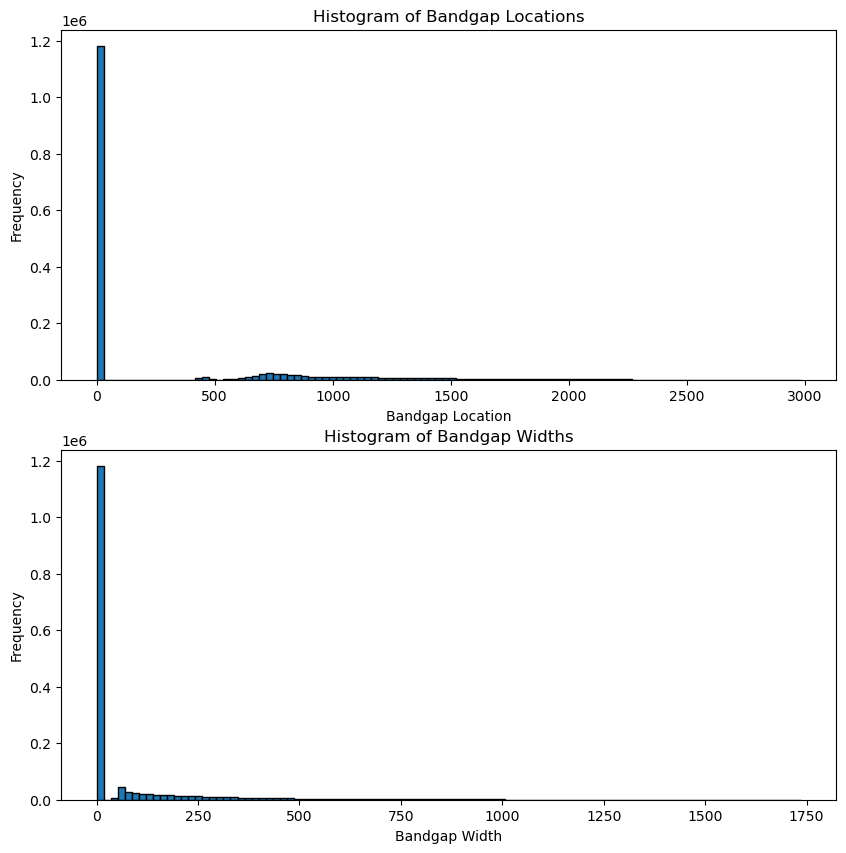

In [50]:
# Plot a 2x1 subplot of the histograms of the bandgap locations and widths, flatten the arrays first
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].hist(bandgap_locations.flatten(), bins=100, edgecolor='black')
axs[0].set_title('Histogram of Bandgap Locations')
axs[0].set_xlabel('Bandgap Location')
axs[0].set_ylabel('Frequency')
axs[1].hist(bandgap_widths.flatten(), bins=100, edgecolor='black')
axs[1].set_title('Histogram of Bandgap Widths')
axs[1].set_xlabel('Bandgap Width')
axs[1].set_ylabel('Frequency')
plt.show()


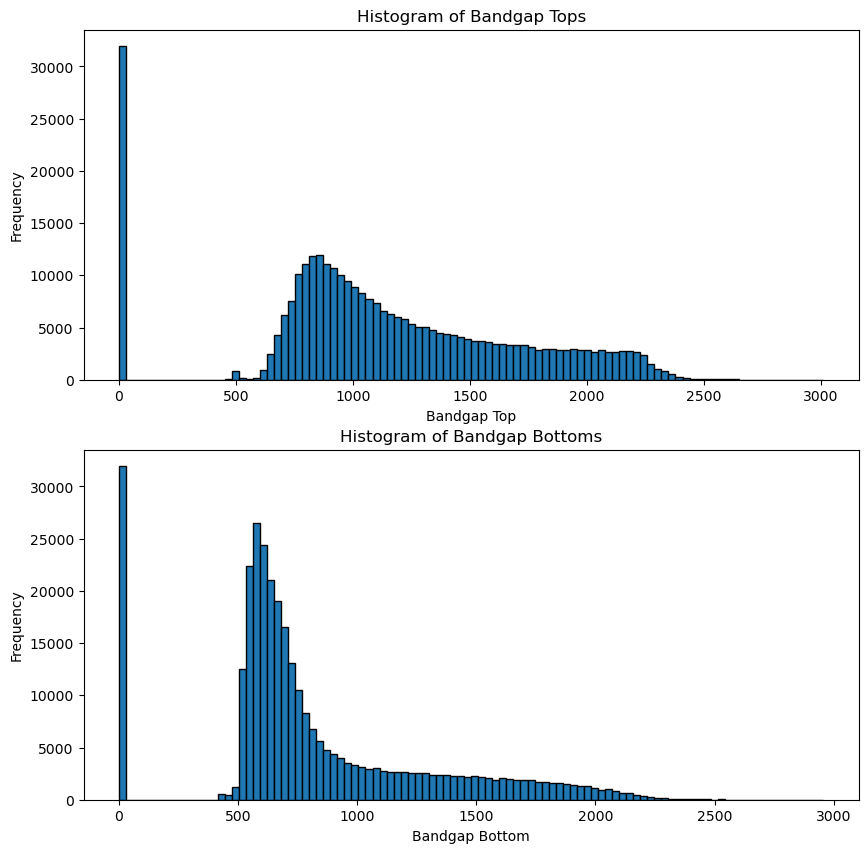

In [51]:
# Plot a 2x1 subplot of the histograms of the bandgap tops and bottoms
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].hist(bandgap_tops, bins=100, edgecolor='black')
axs[0].set_title('Histogram of Bandgap Tops')
axs[0].set_xlabel('Bandgap Top')
axs[0].set_ylabel('Frequency')
axs[1].hist(bandgap_bottoms, bins=100, edgecolor='black')
axs[1].set_title('Histogram of Bandgap Bottoms')
axs[1].set_xlabel('Bandgap Bottom')
axs[1].set_ylabel('Frequency')
plt.show()


In [52]:
def plot_sample_geometry(designs, bandgap_tops, bandgap_bottoms, index=0):
    """
    Plots a single sample geometry from the designs array with additional metadata.
    The title includes the index, bandgap top, and bandgap bottom values.
    The colorbar is adjusted to be the same height as the plot.
    
    Args:
    - designs (np.ndarray): Array containing the designs of shape (n, 32, 32).
    - index (int): Index of the sample to plot.
    - bandgap_tops (np.ndarray): Array of bandgap top values of shape (n,).
    - bandgap_bottoms (np.ndarray): Array of bandgap bottom values of shape (n,).
    """
    # Validate index
    if index < 0 or index >= designs.shape[0]:
        raise ValueError(f"Index {index} is out of bounds for designs array with shape {designs.shape}.")

    # Extract the geometry to plot
    sample_geometry = designs[index]

    # Metadata for the title
    top = float(bandgap_tops[index])  # Convert to scalar float
    bottom = float(bandgap_bottoms[index])  # Convert to scalar float

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(sample_geometry, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Index: {index}, Bandgap Top: {top:.2f}, Bottom: {bottom:.2f}")
    ax.axis("off")  # Remove axis ticks for cleaner visualization

    # Add a colorbar with adjusted height
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Fraction controls height, pad adjusts spacing
    cbar.set_label("Value")  # Label for the colorbar

    # Show the plot
    plt.show()

def extract_bandgap_edges(bandgap_edges, warn_threshold=1, zero_threshold=0.5):
    """
    Extracts the bandgap tops and bottoms for each geometry.
    Prints warnings for:
      - Rows with a single non-zero value.
      - Negative non-zero values.
      - Non-positive differences between top and bottom values.
      - Bandgap differences smaller than warn_threshold.
      - Bandgap set to 0 due to zero_threshold.

    Args:
    - bandgap_edges (np.ndarray): Array of shape (n, 5, 2) containing bandgap edges.
    - warn_threshold (float): Threshold for small bandgap warnings.
    - zero_threshold (float): Minimum difference for a valid bandgap. Below this, a different row is checked.

    Returns:
    - bandgap_tops (np.ndarray): Vector of length n containing the top edges of the bandgap.
    - bandgap_bottoms (np.ndarray): Vector of length n containing the bottom edges of the bandgap.
    """
    n = bandgap_edges.shape[0]  # Number of samples
    bandgap_tops = np.zeros(n)  # Initialize tops
    bandgap_bottoms = np.zeros(n)  # Initialize bottoms

    for i in range(n):
        # Extract the 5x2 array for the current sample
        edges = bandgap_edges[i]

        # Iterate over the rows to find a valid row
        valid_pair = False
        for row in edges:
            non_zero_count = np.count_nonzero(row)  # Count non-zero values in the row
            if non_zero_count == 2:
                # Check for negative non-zero values
                if any(value < 0 for value in row):
                    print(f"Warning: Negative values found in sample {i}, row: {row}")

                # Compute the bandgap top and bottom
                bottom, top  = row[0], row[1]
                difference = top - bottom

                # Check for non-positive difference
                if difference <= 0:
                    print(f"Warning: Non-positive difference in sample {i}, row: {row}")
                    continue  # Move to the next row

                # Check if the difference is between 0 and zero_threshold
                elif 0 < difference < zero_threshold:
                    print(f"Warning: Bandgap difference below zero_threshold ({zero_threshold}) in sample {i}, row: {row}, ignoring this bandgap.")
                    continue  # Skip this row and move to the next

                # Check if the difference is between zero_threshold and warn_threshold
                elif zero_threshold <= difference < warn_threshold:
                    print(f"Warning: Small bandgap detected at index {i}, value: {difference:.6f}, still recorded as valid bandgap.")

                # Assign values to bandgap_tops and bandgap_bottoms
                bandgap_tops[i] = top
                bandgap_bottoms[i] = bottom
                valid_pair = True
                break  # Exit the loop once a valid row is found
            elif non_zero_count == 1:
                # Row has a single non-zero value: print a warning
                print(f"Warning: Row with a single non-zero value detected in sample {i}: {row}")

        if not valid_pair:
            # No valid row found or all rows had differences below zero_threshold
            bandgap_tops[i] = 0
            bandgap_bottoms[i] = 0
            #print(f"Bandgap set to 0 for sample {i} due to zero_threshold ({zero_threshold}).")

    non_zero_count = np.count_nonzero(bandgap_tops)
    print(f"Number of non-zero bandgap_tops and bandgap_bottoms: {non_zero_count} out of {n}")
    return bandgap_tops, bandgap_bottoms

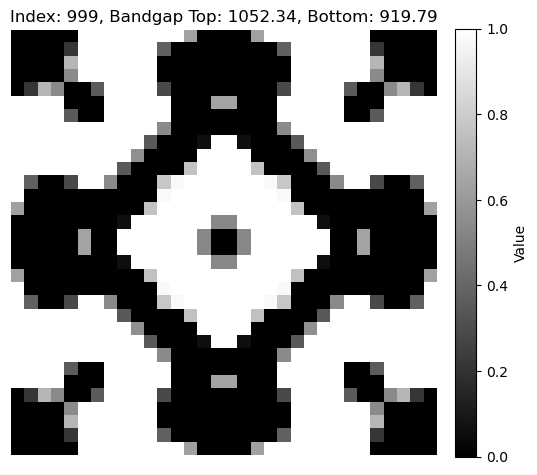

In [53]:
plot_sample_geometry(designs, bandgap_tops, bandgap_bottoms, index=999)

In [54]:
# --- Inlined Sinusoidal Position Embedding ---
# We define it so that it always returns a tensor of shape (B, embedding_dim) given
# an input of shape (B,) (or (B, 1), which is immediately squeezed).
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        # Ensure timesteps is shaped (B,) (i.e. scalar for each batch item)
        # Do not assume an extra singleton dimension!
        if timesteps.dim() == 2:
            timesteps = timesteps.squeeze(1) 
        half_dim = self.embedding_dim // 2
        emb_scale = math.log(10000) / (half_dim - 1)
        # Create a vector of frequencies of shape (half_dim,)
        freqs = torch.exp(torch.arange(half_dim, device=timesteps.device, dtype=torch.float32) * -emb_scale)
        # Multiply timesteps (B,) with frequencies (half_dim,) to produce (B, half_dim)
        args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
        # Concatenate sine and cosine along the last dimension to obtain (B, embedding_dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb


In [55]:
class UNetWithTimeAndBandgap(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, time_embedding_dim=128, bandgap_dim=128):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.GELU(),
            nn.Linear(time_embedding_dim, time_embedding_dim)
        )
        
        self.bandgap_mlp = nn.Sequential(
            nn.Linear(2, bandgap_dim),
            nn.GELU(),
            nn.Linear(bandgap_dim, bandgap_dim)
        )
        
        self.cond_projection = nn.Sequential(
            nn.Linear(bandgap_dim, 512),
            nn.GELU()
        )
        
        # Encoder path (same as before)
        self.inc_conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.inc_bn1 = nn.BatchNorm2d(64)
        self.inc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.inc_bn2 = nn.BatchNorm2d(64)
        
        self.down1_pool = nn.MaxPool2d(2)
        self.down1_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.down1_bn1 = nn.BatchNorm2d(128)
        self.down1_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.down1_bn2 = nn.BatchNorm2d(128)
        
        self.down2_pool = nn.MaxPool2d(2)
        self.down2_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.down2_bn1 = nn.BatchNorm2d(256)
        self.down2_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.down2_bn2 = nn.BatchNorm2d(256)
        
        self.down3_pool = nn.MaxPool2d(2)
        self.down3_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.down3_bn1 = nn.BatchNorm2d(512)
        self.down3_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.down3_bn2 = nn.BatchNorm2d(512)
        
        self.down4_pool = nn.MaxPool2d(2)
        self.down4_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.down4_bn1 = nn.BatchNorm2d(512)
        self.down4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.down4_bn2 = nn.BatchNorm2d(512)
        
        # Decoder path (fixed channel dimensions)
        self.up1_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up1_conv1 = nn.Conv2d(512 + 512, 256, kernel_size=3, padding=1)  # 1024 input channels (512 + 512)
        self.up1_bn1 = nn.BatchNorm2d(256)
        self.up1_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.up1_bn2 = nn.BatchNorm2d(256)
        
        self.up2_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up2_conv1 = nn.Conv2d(256 + 256, 128, kernel_size=3, padding=1)  # 512 input channels (256 + 256)
        self.up2_bn1 = nn.BatchNorm2d(128)
        self.up2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2_bn2 = nn.BatchNorm2d(128)
        
        self.up3_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up3_conv1 = nn.Conv2d(128 + 128, 64, kernel_size=3, padding=1)  # 256 input channels (128 + 128)
        self.up3_bn1 = nn.BatchNorm2d(64)
        self.up3_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up3_bn2 = nn.BatchNorm2d(64)
        
        self.up4_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up4_conv1 = nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1)  # 128 input channels (64 + 64)
        self.up4_bn1 = nn.BatchNorm2d(64)
        self.up4_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up4_bn2 = nn.BatchNorm2d(64)
        
        self.out_conv = nn.Conv2d(64, output_channels, kernel_size=1)
        
    def forward(self, x, t, bandgap):
        # Process condition embeddings
        t_emb = self.time_mlp(t)
        bandgap_emb = self.bandgap_mlp(bandgap)
        combined_emb = t_emb + bandgap_emb
        combined_emb = self.cond_projection(combined_emb)
        combined_emb = combined_emb.unsqueeze(-1).unsqueeze(-1)
        
        # Encoder path
        x1 = F.relu(self.inc_bn1(self.inc_conv1(x)))
        x1 = F.relu(self.inc_bn2(self.inc_conv2(x1)))  # (B, 64, H, W)
        
        x2 = self.down1_pool(x1)
        x2 = F.relu(self.down1_bn1(self.down1_conv1(x2)))
        x2 = F.relu(self.down1_bn2(self.down1_conv2(x2)))  # (B, 128, H/2, W/2)
        
        x3 = self.down2_pool(x2)
        x3 = F.relu(self.down2_bn1(self.down2_conv1(x3)))
        x3 = F.relu(self.down2_bn2(self.down2_conv2(x3)))  # (B, 256, H/4, W/4)
        
        x4 = self.down3_pool(x3)
        x4 = F.relu(self.down3_bn1(self.down3_conv1(x4)))
        x4 = F.relu(self.down3_bn2(self.down3_conv2(x4)))  # (B, 512, H/8, W/8)
        
        x5 = self.down4_pool(x4)
        x5 = F.relu(self.down4_bn1(self.down4_conv1(x5)))
        x5 = F.relu(self.down4_bn2(self.down4_conv2(x5)))  # (B, 512, H/16, W/16)
        
        # Add conditioning
        x5 = x5 + combined_emb
        
        # Decoder path
        x = self.up1_upsample(x5)
        diffY = x4.size()[2] - x.size()[2]
        diffX = x4.size()[3] - x.size()[3]
        x = F.pad(x, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x4, x], dim=1)  # (B, 1024, H/8, W/8)
        x = F.relu(self.up1_bn1(self.up1_conv1(x)))
        x = F.relu(self.up1_bn2(self.up1_conv2(x)))
        
        x = self.up2_upsample(x)
        diffY = x3.size()[2] - x.size()[2]
        diffX = x3.size()[3] - x.size()[3]
        x = F.pad(x, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x3, x], dim=1)  # (B, 512, H/4, W/4)
        x = F.relu(self.up2_bn1(self.up2_conv1(x)))
        x = F.relu(self.up2_bn2(self.up2_conv2(x)))
        
        x = self.up3_upsample(x)
        diffY = x2.size()[2] - x.size()[2]
        diffX = x2.size()[3] - x.size()[3]
        x = F.pad(x, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x], dim=1)  # (B, 256, H/2, W/2)
        x = F.relu(self.up3_bn1(self.up3_conv1(x)))
        x = F.relu(self.up3_bn2(self.up3_conv2(x)))
        
        x = self.up4_upsample(x)
        diffY = x1.size()[2] - x.size()[2]
        diffX = x1.size()[3] - x.size()[3]
        x = F.pad(x, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x1, x], dim=1)  # (B, 128, H, W)
        x = F.relu(self.up4_bn1(self.up4_conv1(x)))
        x = F.relu(self.up4_bn2(self.up4_conv2(x)))
        
        return self.out_conv(x)

In [56]:
# Define the forward diffusion process
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Add Gaussian noise to input images based on the timestep.
    Args:
    - x_0 (torch.Tensor): Clean input images of shape (batch, channels, H, W).
    - t (torch.Tensor): Timestep scalar tensor of shape (batch,).
    - noise (torch.Tensor): Optional noise to add; otherwise, sampled from normal distribution.
    Returns:
    - x_t: Noisy image at timestep t.
    - noise: The added noise.
    """
    if noise is None:
        noise = torch.randn_like(x_0)  # Generate Gaussian noise
    alpha_t = (1 - t / t.max()).view(-1, 1, 1, 1)  # Linearly decreasing variance schedule
    x_t = alpha_t * x_0 + (1 - alpha_t) * noise  # Add noise proportional to alpha_t
    return x_t, noise

# Take a sample image and generate multiple levels of noise for it to test above function.
import matplotlib.pyplot as plt

# Get a sample image from the dataset
sample_image = designs[0]  # Take the first image

# Define noise steps to visualize
noise_steps = [5, 10, 20, 40, 80, 160, 320]

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Plot the original image
axes[0].imshow(sample_image[0].permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')

# Generate and plot noisy images at different timesteps
for i, step in enumerate(noise_steps):
    # Create a timestep tensor
    t = torch.tensor([step], device=device)
    
    # Apply forward diffusion
    noisy_image, _ = forward_diffusion_sample(sample_image, t)
    
    # Plot the noisy image
    axes[i+1].imshow(noisy_image[0].permute(1, 2, 0).cpu().numpy())
    axes[i+1].set_title(f"t={step}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

# Training function
def train_diffusion_model(
    model,
    train_dataloader,
    val_dataloader,
    num_timesteps=200,
    epochs=20,
    criterion=nn.MSELoss(),
    device="cuda",
    output_folder="output",
    save_intermediates=True,
    track_losses=True,
):
    """
    Train the diffusion model with optional intermediate model saving and loss tracking.
    
    Args:
        model: The UNet model to train
        train_dataloader: DataLoader for training data
        val_dataloader: DataLoader for validation data
        num_timesteps: Number of diffusion steps
        epochs: Number of training epochs
        device: Device to train on ("cuda" or "cpu")
        output_folder: Where to save model checkpoints and logs
        save_intermediates: Whether to save intermediate model checkpoints
        track_losses: Whether to track and plot training/validation losses
        criterion: Loss function to use (default: MSELoss)
    """
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    
    device = torch.device(device)
    model.to(device)
    model.train()

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize lists to track losses
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        epoch_train_loss = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Train]") as pbar:
            for batch in pbar:
                images, bandgap_tops, bandgap_bottoms = batch
                images = images.to(device)
                bandgap_tops = bandgap_tops.to(device)
                bandgap_bottoms = bandgap_bottoms.to(device)

                # Ensure images have the correct channel dimension
                if images.ndim == 3:
                    images = images.unsqueeze(1)

                # Combine bandgap_tops and bandgap_bottoms into a single tensor
                bandgap_conditions = torch.stack([bandgap_tops, bandgap_bottoms], dim=1)

                # Sample random timesteps for the batch
                timesteps = torch.randint(1, num_timesteps + 1, (images.size(0),), device=device).float()

                # Forward diffusion process (add noise)
                noisy_images, noise = forward_diffusion_sample(images, timesteps)

                # Predict noise from the noisy images
                predicted_noise = model(noisy_images, timesteps, bandgap_conditions)

                # Compute loss
                loss = criterion(predicted_noise, noise)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update TQDM progress bar
                epoch_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

        avg_train_loss = epoch_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss)

        # Validation Loss
        model.eval()  # Set model to evaluation mode
        epoch_val_loss = 0
        with torch.no_grad():
            with tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Validation]") as pbar:
                for batch in pbar:
                    images, bandgap_tops, bandgap_bottoms = batch
                    images = images.to(device)
                    bandgap_tops = bandgap_tops.to(device)
                    bandgap_bottoms = bandgap_bottoms.to(device)

                    if images.ndim == 3:
                        images = images.unsqueeze(1)

                    bandgap_conditions = torch.stack([bandgap_tops, bandgap_bottoms], dim=1)
                    timesteps = torch.randint(1, num_timesteps + 1, (images.size(0),), device=device).float()
                    noisy_images, noise = forward_diffusion_sample(images, timesteps)
                    predicted_noise = model(noisy_images, timesteps, bandgap_conditions)
                    val_loss = criterion(predicted_noise, noise)
                    epoch_val_loss += val_loss.item()
                    pbar.set_postfix(val_loss=val_loss.item())

        avg_val_loss = epoch_val_loss / len(val_dataloader)
        validation_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

        # Save model checkpoint
        if save_intermediates:
            model_path = os.path.join(output_folder, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Saved intermediate model to {model_path}")

    # Save the final model
    final_model_path = os.path.join(output_folder, "model_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved final model to {final_model_path}")

    # Track losses
    if track_losses:
        # Save losses to CSV
        losses_csv_path = os.path.join(output_folder, "losses.csv")
        with open(losses_csv_path, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Epoch", "Train Loss", "Validation Loss"])
            for epoch, (train_loss, val_loss) in enumerate(zip(training_losses, validation_losses), start=1):
                writer.writerow([epoch, train_loss, val_loss])
        print(f"Saved losses to {losses_csv_path}")

        # Plot losses
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
        plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Over Epochs")
        plt.legend()
        plt.grid(True)
        plt_path = os.path.join(output_folder, "loss_plot.png")
        plt.savefig(plt_path)
        print(f"Saved loss plot to {plt_path}")
        plt.show()

In [57]:
# Create Dataset
batch_size = 32
images = torch.tensor(designs, dtype=torch.float32)
bandgap_tops = torch.tensor(bandgap_tops, dtype=torch.float32)
bandgap_bottoms = torch.tensor(bandgap_bottoms, dtype=torch.float32)

dataset = TensorDataset(images, bandgap_tops, bandgap_bottoms)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [58]:
input_channels = 1  # Single channel for geometry images
output_channels = 1  # Single channel for noise prediction
time_embedding_dim = 128  # Dimensionality of timestep embedding
bandgap_dim = 128  # Dimensionality of bandgap condition embedding

model = UNetWithTimeAndBandgap(
    input_channels=input_channels, 
    output_channels=output_channels, 
    time_embedding_dim=time_embedding_dim, 
    bandgap_dim=bandgap_dim
)

In [59]:
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super().__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1  # Since we're working with grayscale images
        self.window = self.create_window(window_size)
        
    def gaussian(self, window_size, sigma=1.5):
        """
        Create a gaussian kernel using PyTorch operations for gradient tracking
        """
        # Create coordinates
        x = torch.arange(window_size, dtype=torch.float32)
        # Center coordinates at zero
        x = x - window_size//2
        # Calculate gaussian values using torch.exp
        gauss = torch.exp(-(x * x)/(2 * sigma * sigma))
        return gauss/gauss.sum()
        
    def create_window(self, window_size):
        _1D_window = self.gaussian(window_size).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(self.channel, 1, window_size, window_size).contiguous()
        return window
    
    def forward(self, pred, target):
        window = self.window.to(pred.device)
        
        # Constants for stability
        L = 1  # Dynamic range of pixel values
        K1 = 0.01
        K2 = 0.03
        C1 = (K1 * L) ** 2
        C2 = (K2 * L) ** 2
        
        # Compute means
        mu1 = F.conv2d(pred, window, padding=self.window_size//2, groups=self.channel)
        mu2 = F.conv2d(target, window, padding=self.window_size//2, groups=self.channel)
        
        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2
        
        # Compute variances and covariance
        sigma1_sq = F.conv2d(pred * pred, window, padding=self.window_size//2, groups=self.channel) - mu1_sq
        sigma2_sq = F.conv2d(target * target, window, padding=self.window_size//2, groups=self.channel) - mu2_sq
        sigma12 = F.conv2d(pred * target, window, padding=self.window_size//2, groups=self.channel) - mu1_mu2
        
        # Compute SSIM
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
                   ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        
        if self.size_average:
            ssim_loss = 1 - ssim_map.mean()
        else:
            ssim_loss = 1 - ssim_map.mean(1).mean(1).mean(1)
        
        return ssim_loss

Epoch 1/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.64it/s, val_loss=0.0223]


Epoch 1/50, Train Loss: 0.029486, Validation Loss: 0.028426
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_1.pth


Epoch 2/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.06it/s, val_loss=0.0224]


Epoch 2/50, Train Loss: 0.028852, Validation Loss: 0.028977
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_2.pth


Epoch 3/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.67it/s, val_loss=0.0248]


Epoch 3/50, Train Loss: 0.028465, Validation Loss: 0.027112
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_3.pth


Epoch 4/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 152.11it/s, val_loss=0.0259]


Epoch 4/50, Train Loss: 0.027873, Validation Loss: 0.028360
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_4.pth


Epoch 5/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.84it/s, val_loss=0.0367]


Epoch 5/50, Train Loss: 0.027442, Validation Loss: 0.027232
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_5.pth


Epoch 6/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.16it/s, val_loss=0.0254]


Epoch 6/50, Train Loss: 0.027059, Validation Loss: 0.028364
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_6.pth


Epoch 7/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.33it/s, val_loss=0.0194] 


Epoch 7/50, Train Loss: 0.026652, Validation Loss: 0.026372
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_7.pth


Epoch 8/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.63it/s, val_loss=0.0336]


Epoch 8/50, Train Loss: 0.026387, Validation Loss: 0.026919
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_8.pth


Epoch 9/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.77it/s, val_loss=0.0182] 


Epoch 9/50, Train Loss: 0.026223, Validation Loss: 0.026226
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_9.pth


Epoch 10/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.68it/s, val_loss=0.0242]


Epoch 10/50, Train Loss: 0.025818, Validation Loss: 0.026163
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_10.pth


Epoch 11/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.30it/s, val_loss=0.0169]


Epoch 11/50, Train Loss: 0.025657, Validation Loss: 0.025380
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_11.pth


Epoch 12/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.69it/s, val_loss=0.0202]


Epoch 12/50, Train Loss: 0.025435, Validation Loss: 0.025969
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_12.pth


Epoch 13/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.46it/s, val_loss=0.0236] 


Epoch 13/50, Train Loss: 0.025102, Validation Loss: 0.024871
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_13.pth


Epoch 14/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.39it/s, val_loss=0.0152]


Epoch 14/50, Train Loss: 0.024913, Validation Loss: 0.025716
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_14.pth


Epoch 15/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.02it/s, val_loss=0.021] 


Epoch 15/50, Train Loss: 0.024807, Validation Loss: 0.024552
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_15.pth


Epoch 16/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.82it/s, val_loss=0.0184]


Epoch 16/50, Train Loss: 0.024556, Validation Loss: 0.024000
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_16.pth


Epoch 17/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.00it/s, val_loss=0.0227] 


Epoch 17/50, Train Loss: 0.024293, Validation Loss: 0.024598
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_17.pth


Epoch 18/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.84it/s, val_loss=0.0221]


Epoch 18/50, Train Loss: 0.024092, Validation Loss: 0.024964
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_18.pth


Epoch 19/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.08it/s, val_loss=0.0234] 


Epoch 19/50, Train Loss: 0.023922, Validation Loss: 0.024220
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_19.pth


Epoch 20/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.75it/s, val_loss=0.0142]


Epoch 20/50, Train Loss: 0.023817, Validation Loss: 0.024121
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_20.pth


Epoch 21/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.75it/s, val_loss=0.018] 


Epoch 21/50, Train Loss: 0.023577, Validation Loss: 0.024894
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_21.pth


Epoch 22/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.29it/s, val_loss=0.0183]


Epoch 22/50, Train Loss: 0.023550, Validation Loss: 0.023766
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_22.pth


Epoch 23/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.74it/s, val_loss=0.0293]


Epoch 23/50, Train Loss: 0.023408, Validation Loss: 0.023547
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_23.pth


Epoch 24/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.96it/s, val_loss=0.0221]


Epoch 24/50, Train Loss: 0.023287, Validation Loss: 0.023332
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_24.pth


Epoch 25/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.20it/s, val_loss=0.016] 


Epoch 25/50, Train Loss: 0.023216, Validation Loss: 0.025615
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_25.pth


Epoch 26/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 152.03it/s, val_loss=0.0252]


Epoch 26/50, Train Loss: 0.022927, Validation Loss: 0.023111
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_26.pth


Epoch 27/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.58it/s, val_loss=0.0241] 


Epoch 27/50, Train Loss: 0.022841, Validation Loss: 0.022976
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_27.pth


Epoch 28/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.74it/s, val_loss=0.0295]


Epoch 28/50, Train Loss: 0.022723, Validation Loss: 0.024261
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_28.pth


Epoch 29/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.39it/s, val_loss=0.0206]


Epoch 29/50, Train Loss: 0.022713, Validation Loss: 0.023772
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_29.pth


Epoch 30/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.73it/s, val_loss=0.0229]


Epoch 30/50, Train Loss: 0.022497, Validation Loss: 0.023461
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_30.pth


Epoch 31/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.83it/s, val_loss=0.0207]


Epoch 31/50, Train Loss: 0.022432, Validation Loss: 0.022554
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_31.pth


Epoch 32/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.02it/s, val_loss=0.0412]


Epoch 32/50, Train Loss: 0.022474, Validation Loss: 0.022484
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_32.pth


Epoch 33/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.20it/s, val_loss=0.019]  


Epoch 33/50, Train Loss: 0.022342, Validation Loss: 0.022286
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_33.pth


Epoch 34/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.33it/s, val_loss=0.0215]


Epoch 34/50, Train Loss: 0.022256, Validation Loss: 0.023232
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_34.pth


Epoch 35/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 147.80it/s, val_loss=0.0146]


Epoch 35/50, Train Loss: 0.022090, Validation Loss: 0.022771
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_35.pth


Epoch 36/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.22it/s, val_loss=0.0251]


Epoch 36/50, Train Loss: 0.022082, Validation Loss: 0.022969
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_36.pth


Epoch 37/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.32it/s, val_loss=0.028] 


Epoch 37/50, Train Loss: 0.021996, Validation Loss: 0.022418
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_37.pth


Epoch 38/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.47it/s, val_loss=0.0175]


Epoch 38/50, Train Loss: 0.022040, Validation Loss: 0.023825
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_38.pth


Epoch 39/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.19it/s, val_loss=0.0182] 


Epoch 39/50, Train Loss: 0.021803, Validation Loss: 0.022297
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_39.pth


Epoch 40/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.46it/s, val_loss=0.0135] 


Epoch 40/50, Train Loss: 0.021706, Validation Loss: 0.022172
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_40.pth


Epoch 41/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.21it/s, val_loss=0.0211]


Epoch 41/50, Train Loss: 0.021695, Validation Loss: 0.022629
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_41.pth


Epoch 42/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.60it/s, val_loss=0.0152] 


Epoch 42/50, Train Loss: 0.021683, Validation Loss: 0.023811
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_42.pth


Epoch 43/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.52it/s, val_loss=0.0143]


Epoch 43/50, Train Loss: 0.021638, Validation Loss: 0.021748
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_43.pth


Epoch 44/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.33it/s, val_loss=0.0333] 


Epoch 44/50, Train Loss: 0.021502, Validation Loss: 0.024479
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_44.pth


Epoch 45/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 147.81it/s, val_loss=0.0147] 


Epoch 45/50, Train Loss: 0.021365, Validation Loss: 0.021797
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_45.pth


Epoch 46/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 148.86it/s, val_loss=0.0189]


Epoch 46/50, Train Loss: 0.021324, Validation Loss: 0.021748
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_46.pth


Epoch 47/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.76it/s, val_loss=0.032]  


Epoch 47/50, Train Loss: 0.021266, Validation Loss: 0.022538
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_47.pth


Epoch 48/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 151.71it/s, val_loss=0.0235] 


Epoch 48/50, Train Loss: 0.021171, Validation Loss: 0.021816
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_48.pth


Epoch 49/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 149.91it/s, val_loss=0.0198] 


Epoch 49/50, Train Loss: 0.021168, Validation Loss: 0.020978
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_49.pth


Epoch 50/50 [Validation]: 100%|██████████| 1995/1995 [00:13<00:00, 150.37it/s, val_loss=0.02]   


Epoch 50/50, Train Loss: 0.021080, Validation Loss: 0.022506
Saved intermediate model to ./diffusion_models\20250408_233652\model_epoch_50.pth
Saved final model to ./diffusion_models\20250408_233652\model_final.pth
Saved losses to ./diffusion_models\20250408_233652\losses.csv
Saved loss plot to ./diffusion_models\20250408_233652\loss_plot.png


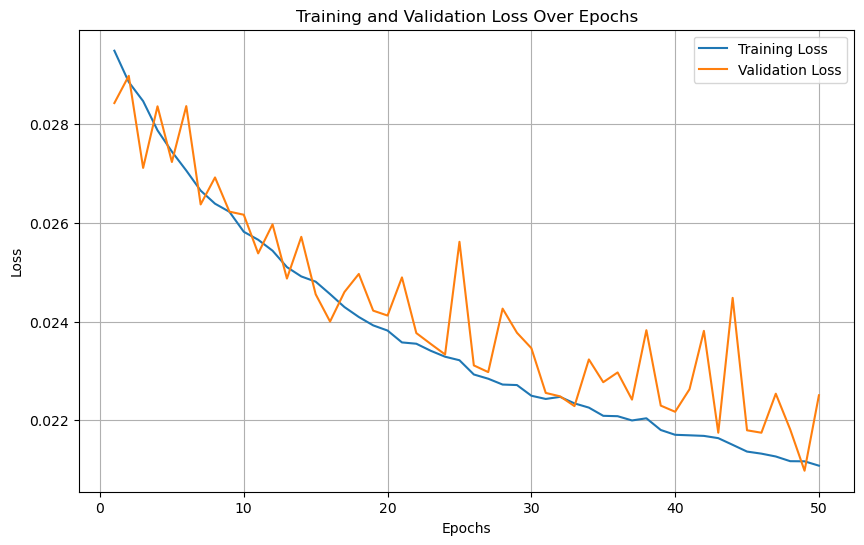

In [61]:
training_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = os.path.join("./diffusion_models", training_timestamp)

ssim_criterion = SSIMLoss(window_size=11)
train_diffusion_model(
    model,
    train_dataloader,
    val_dataloader,
    num_timesteps=200,
    epochs=50,
    device="cuda",
    #criterion=ssim_criterion, #default is mse
    output_folder=output_folder,
    save_intermediates=True,
    track_losses=True
)

In [62]:
def get_noise_schedule(t, num_timesteps, schedule_type="cosine"):
    """
    Returns noise schedule for timestep t.
    Supports 'linear', 'cosine', and 'exponential' schedules.

    Args:
        t (int): Current timestep
        num_timesteps (int): Total number of diffusion steps
        schedule_type (str): Type of schedule - "linear", "cosine", or "exponential"

    Returns:
        float: Alpha value for current timestep
    """
    if schedule_type == "linear":
        return 1 - t/num_timesteps
    elif schedule_type == "cosine":
        # Improved schedule from Ho et al.
        s = 0.008
        t = t / num_timesteps
        return np.cos((t + s)/(1 + s) * np.pi/2) ** 2
    else: # exponential
        return 0.99 ** t

def get_variance_schedule(t, num_timesteps, schedule_type="exponential"):
    """
    Returns variance schedule for noise prediction

    Args:
        t (int): Current timestep
        num_timesteps (int): Total number of diffusion steps
        schedule_type (str): Type of schedule - currently only "exponential" supported

    Returns:
        float: Beta (variance) value for current timestep
    """
    if schedule_type == "exponential":
        beta_start = 0.0001
        beta_end = 0.02
        return beta_start + t * (beta_end - beta_start) / num_timesteps
    return 0.0001  # Default fallback

def normalize_bandgap_conditions(bandgap_top, bandgap_bottom, max_bandgap=2000.0):
    """
    Normalize bandgap conditions to [0,1] range

    Args:
        bandgap_top (float): Upper bandgap frequency
        bandgap_bottom (float): Lower bandgap frequency
        max_bandgap (float): Maximum expected bandgap frequency

    Returns:
        tuple: Normalized (top, bottom) values
    """
    return bandgap_top/max_bandgap, bandgap_bottom/max_bandgap

def generate_image_fixed(model, bandgap_top, bandgap_bottom, num_timesteps=200,
                        device="cuda", image_size=32,
                        noise_schedule_type="cosine",
                        variance_schedule_type="exponential",
                        guidance_scale=3.0,
                        max_norm=1.0):
    """
    Generate an image given bandgap conditions using the trained diffusion model.
    Includes improved noise scheduling, variance scheduling, and classifier-free guidance.

    Args:
        model: The diffusion model
        bandgap_top (float): Upper bandgap frequency
        bandgap_bottom (float): Lower bandgap frequency
        num_timesteps (int): Number of diffusion steps
        device (str): Device to run on ("cuda" or "cpu")
        image_size (int): Size of generated image
        noise_schedule_type (str): Type of noise schedule
        variance_schedule_type (str): Type of variance schedule
        guidance_scale (float): Scale factor for classifier-free guidance
        max_norm (float): Maximum norm for gradient clipping

    Returns:
        tuple: (final_image, initial_noise)
    """
    model.eval()
    model.to(device)

    # Initialize with Gaussian noise
    x_t = torch.randn(1, 1, image_size, image_size, device=device)
    x_i = x_t.clone()  # Save initial noise for visualization

    # Normalize conditions
    norm_top, norm_bottom = normalize_bandgap_conditions(bandgap_top, bandgap_bottom)

    # Create conditioning tensors for guided and unguided prediction
    bandgap_conditions = torch.tensor([[norm_top, norm_bottom]],
                                    dtype=torch.float32, device=device)
    uncond_conditions = torch.zeros_like(bandgap_conditions)

    # Keep track of last valid prediction
    last_valid_x = x_t.clone()

    with torch.no_grad():
        for t in range(num_timesteps, 0, -1):
            # Create timestep tensor
            t_tensor = torch.tensor([[t]], dtype=torch.float32, device=device)

            try:
                # Get schedule values for current timestep
                alpha_t = torch.tensor(get_noise_schedule(t, num_timesteps, noise_schedule_type),
                                     device=device)
                beta_t = torch.tensor(get_variance_schedule(t, num_timesteps, variance_schedule_type),
                                    device=device)
                sigma_t = torch.sqrt(beta_t)

                # Predict noise with and without conditions
                noise_pred_cond = model(x_t, t_tensor, bandgap_conditions)
                noise_pred_uncond = model(x_t, t_tensor, uncond_conditions)

                # Apply classifier-free guidance
                predicted_noise = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # Clip predicted noise
                predicted_noise = torch.clamp(predicted_noise, -max_norm, max_norm)

                # Check for NaN
                if torch.any(torch.isnan(predicted_noise)):
                    print(f"NaN detected in predicted noise at timestep {t}")
                    x_t = last_valid_x
                    break

                # Update x_t using improved noise prediction
                x_t = (x_t - (1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)

                # Add noise except at final step
                if t > 1:
                    noise = torch.randn_like(x_t)
                    x_t = x_t + sigma_t * noise

                # Check for NaN in x_t
                if torch.any(torch.isnan(x_t)):
                    print(f"NaN detected in x_t at timestep {t}")
                    x_t = last_valid_x
                    break

                # Store last valid prediction
                last_valid_x = x_t.clone()

            except Exception as e:
                print(f"Error at timestep {t}: {str(e)}")
                x_t = last_valid_x
                break

    # Ensure final image is in valid range
    final_image = torch.clamp(x_t, 0, 1)

    return final_image.cpu(), x_i.cpu()

def generate_image(model, bandgap_top, bandgap_bottom, num_timesteps=200, device="cuda", image_size=32):
    """
    Generate an image given bandgap conditions using the trained diffusion model.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    # Initialize Gaussian noise
    x_t = torch.randn(1, 1, image_size, image_size, device=device)  # Start with pure noise

    # Create conditioning tensors
    bandgap_conditions = torch.tensor([[bandgap_top, bandgap_bottom]], dtype=torch.float32, device=device)
    t_tensor = torch.tensor([[num_timesteps]], dtype=torch.float32, device=device)

    # Process bandgap and time embeddings using the model's embedding layers
    bandgap_emb = model.bandgap_embedding(bandgap_conditions)  # Shape: (1, 128)
    t_emb = model.time_embedding(t_tensor)  # Shape: (1, 128)
    combined_emb = bandgap_emb + t_emb  # Combine embeddings

    # Project combined embedding to match bottleneck channels
    projected_emb = model.embedding_projection(combined_emb).view(1, 1024, 1, 1)  # Shape: (1, 1024, 1, 1)

    # Iterative reverse diffusion process
    with torch.no_grad():
        for t in range(num_timesteps, 0, -1):
            t_tensor = torch.tensor([[t]], dtype=torch.float32, device=device)  # Update timestep tensor
            predicted_noise = model(x_t, t_tensor, bandgap_conditions)  # Predict noise
            alpha_t = torch.tensor(1 - t / num_timesteps, device=device)  # Compute alpha_t
            x_t = (x_t - (1 - alpha_t) * predicted_noise) / alpha_t.clamp(min=1e-6)  # Update x_t

    # Final denoised image
    final_image = x_t.clamp(0, 1)  # Clamp to [0, 1] for visualization

    return final_image.cpu()

def plot_generated_image(image_tensor, bandgap_top, bandgap_bottom, timestep, title=None, save_path=None):
    """
    Plot a generated image from a diffusion model output with metadata in the title.
    The title includes the bandgap top and bandgap bottom values.
    The colorbar is adjusted to be the same height as the plot.

    Args:
    - image_tensor (torch.Tensor): The generated image tensor of shape (1, 1, H, W).
    - bandgap_top (float): Bandgap top value.
    - bandgap_bottom (float): Bandgap bottom value.
    - title (str): Optional title for the plot. If None, a default title is created.
    - save_path (str): Optional path to save the plot as an image file.
    """
    # Remove batch and channel dimensions
    image = image_tensor.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (H, W)

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(image, cmap='gray_r', vmin=0, vmax=1)

    # Add title with metadata
    if title is None:
        title = f"Bandgap Top: {bandgap_top:.2f}, Bottom: {bandgap_bottom:.2f}, Timestep: {timestep:.2f}"
    ax.set_title(title)
    ax.axis("off")  # Remove axis ticks for cleaner visualization

    # Add a colorbar with adjusted height
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Value")  # Label for the colorbar

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved plot to {save_path}")
    else:
        plt.show()

NaN detected in predicted noise at timestep 183
torch.Size([1, 1, 32, 32])
Saved plot to generated_image_with_metadata.png


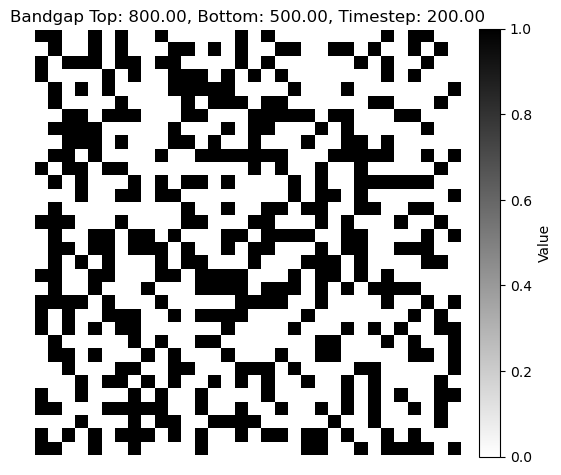

In [63]:
bandgap_top = 800
bandgap_bottom = 500
timesteps = 200
generated_image, initial_noise = generate_image_fixed(
    model,
    bandgap_top=bandgap_top,
    bandgap_bottom=bandgap_bottom,
    num_timesteps=timesteps,
    device="cuda",
    noise_schedule_type="cosine",
    guidance_scale=3.0
)
print(generated_image.shape)

# Plot the generated image
plot_generated_image(
    generated_image,
    bandgap_top=bandgap_top,
    bandgap_bottom=bandgap_bottom,
    timestep=timesteps,
    title=None,
    save_path="generated_image_with_metadata.png"
)
